# TPS-Feb-2022

In [1]:
NB = '118'
dataset_NB = '006'

## Import libralies

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats import mode
import time

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping

## Load and check data

In [3]:
# Load data
##### Load train and Test set
train = pd.read_pickle(f"../data/processed/nb{dataset_NB}_train.pkl", compression='zip')
test = pd.read_pickle(f"../data/processed/nb{dataset_NB}_test.pkl", compression='zip')

submission = pd.read_csv('../data/raw/sample_submission.csv')

## Parameter Setting

In [4]:
RANDOM_STATE = 13
FOLDS = 10
TARGET = 'target'
FEATURES = [col for col in train.columns if col not in ['row_id', TARGET]]

FEATURES

['A0T0G0C10',
 'A0T0G1C9',
 'A0T0G2C8',
 'A0T0G3C7',
 'A0T0G4C6',
 'A0T0G5C5',
 'A0T0G6C4',
 'A0T0G7C3',
 'A0T0G8C2',
 'A0T0G9C1',
 'A0T0G10C0',
 'A0T1G0C9',
 'A0T1G1C8',
 'A0T1G2C7',
 'A0T1G3C6',
 'A0T1G4C5',
 'A0T1G5C4',
 'A0T1G6C3',
 'A0T1G7C2',
 'A0T1G8C1',
 'A0T1G9C0',
 'A0T2G0C8',
 'A0T2G1C7',
 'A0T2G2C6',
 'A0T2G3C5',
 'A0T2G4C4',
 'A0T2G5C3',
 'A0T2G6C2',
 'A0T2G7C1',
 'A0T2G8C0',
 'A0T3G0C7',
 'A0T3G1C6',
 'A0T3G2C5',
 'A0T3G3C4',
 'A0T3G4C3',
 'A0T3G5C2',
 'A0T3G6C1',
 'A0T3G7C0',
 'A0T4G0C6',
 'A0T4G1C5',
 'A0T4G2C4',
 'A0T4G3C3',
 'A0T4G4C2',
 'A0T4G5C1',
 'A0T4G6C0',
 'A0T5G0C5',
 'A0T5G1C4',
 'A0T5G2C3',
 'A0T5G3C2',
 'A0T5G4C1',
 'A0T5G5C0',
 'A0T6G0C4',
 'A0T6G1C3',
 'A0T6G2C2',
 'A0T6G3C1',
 'A0T6G4C0',
 'A0T7G0C3',
 'A0T7G1C2',
 'A0T7G2C1',
 'A0T7G3C0',
 'A0T8G0C2',
 'A0T8G1C1',
 'A0T8G2C0',
 'A0T9G0C1',
 'A0T9G1C0',
 'A0T10G0C0',
 'A1T0G0C9',
 'A1T0G1C8',
 'A1T0G2C7',
 'A1T0G3C6',
 'A1T0G4C5',
 'A1T0G5C4',
 'A1T0G6C3',
 'A1T0G7C2',
 'A1T0G8C1',
 'A1T0G9C0',
 'A1T1G0C

## Modeling

### 目的変数（target）を数値に変換する

In [5]:
encoder = LabelEncoder()
train[TARGET] = encoder.fit_transform(train[TARGET])

In [6]:
train.head()

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,target,mean,std,min,max,median,25%,75%,skew,kurt
0,0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,9,2.767028e-17,0.005643,-0.014033,0.023992,-0.000687,-0.002403,-0.000043,1.307963,4.111766
1,1,-9.536743e-07,-0.000010,-0.000043,0.000886,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,...,6,1.129996e-17,0.001751,-0.005016,0.008984,-0.000086,-0.000801,0.000796,0.696087,4.551135
2,2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,...,6,-1.785171e-18,0.000601,-0.002587,0.002327,0.000015,-0.000124,0.000201,-0.415096,4.174590
3,3,4.632568e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,...,6,-4.829865e-19,0.001160,-0.005403,0.004602,0.000019,-0.000230,0.000394,-0.395986,4.501727
4,4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,2,2.872491e-17,0.007117,-0.024033,0.037984,-0.000343,-0.002403,-0.000043,1.250485,6.388081


In [7]:
train.shape

(200000, 297)

### ExtraTreeClassifier

In [8]:
predictions, scores = [], []
result = {}
feature_importance = []

k = StratifiedKFold(n_splits=FOLDS, random_state=RANDOM_STATE, shuffle=True)
for i, (train_idx, val_idx) in enumerate(k.split(train[FEATURES], train[TARGET])):

    ### make dataset
    X_train, X_val = train.iloc[train_idx][FEATURES], train.iloc[val_idx][FEATURES]
    y_train, y_val = train[TARGET].iloc[train_idx] , train[TARGET].iloc[val_idx]

    ### training
    model = ExtraTreesClassifier(n_estimators=1111, n_jobs=-1)
    model.fit(X_train, y_train)

    ### inference(validation)
    val_pred = model.predict(X_val)
    val_score = accuracy_score(y_val, val_pred)
    print(f'Fold {i+1} accuracy score: {round(val_score, 4)}')
    result[f'Fold{i+1}_yval'] = y_val
    result[f'Fold{i+1}_pred'] = val_pred
    scores.append(val_score)

    ### feature importance
    feat_imp = pd.DataFrame(index=FEATURES, data=model.feature_importances_, columns=[f'Fold{i+1}_importance'])
    feature_importance.append(feat_imp)

    ### inference(test)
    predictions.append(model.predict_proba(test[FEATURES]))

print('')
print(f'Mean accuracy - {round(np.mean(scores), 4)}')

Fold 1 accuracy score: 0.9966
Fold 2 accuracy score: 0.997
Fold 3 accuracy score: 0.997
Fold 4 accuracy score: 0.9962
Fold 5 accuracy score: 0.9962
Fold 6 accuracy score: 0.9972
Fold 7 accuracy score: 0.9964
Fold 8 accuracy score: 0.9961
Fold 9 accuracy score: 0.9967
Fold 10 accuracy score: 0.9966

Mean accuracy - 0.9966


### Feature Importance

<AxesSubplot:title={'center':'Feature Importance Across Folds'}>

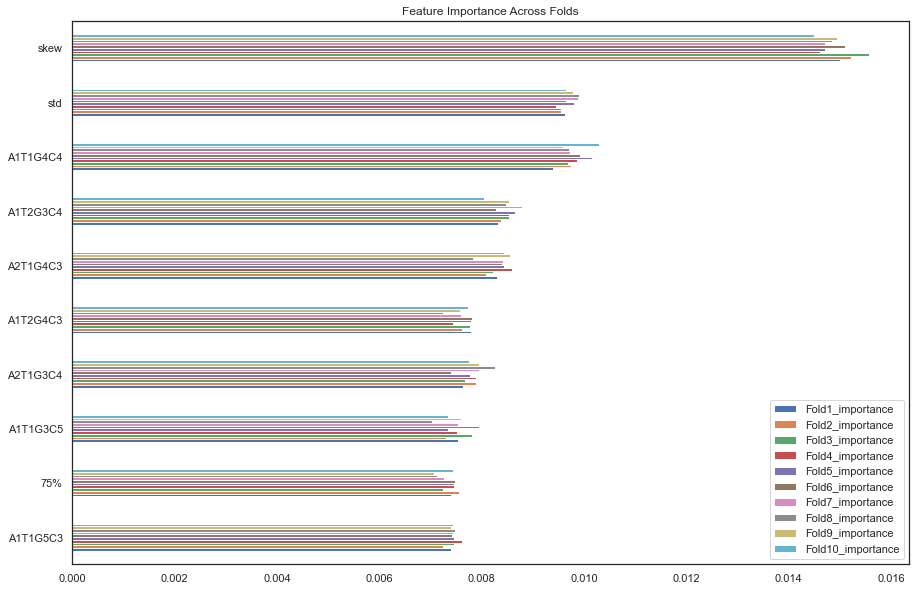

In [9]:
### feature importance
feat_imp = pd.concat(feature_importance, axis=1)

#feat_imp_gcd_large = feat_imp[f'Fold{i+1}_importance' for i in range(FOLDS)]
feat_imp.sort_values('Fold1_importance').tail(10).plot(kind='barh', figsize=(15, 10), title='Feature Importance Across Folds')

### Confusion Matrix

Text(111.5, 0.5, 'True')

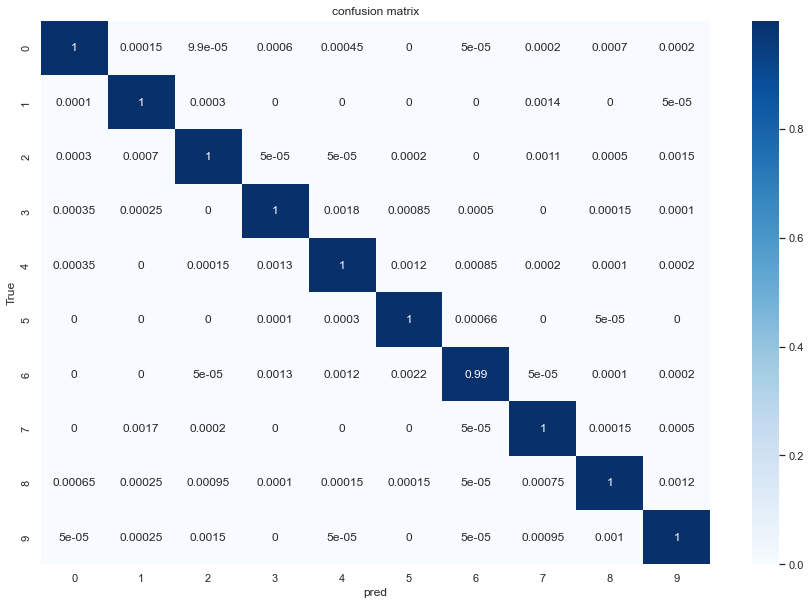

In [10]:
for fold in range(FOLDS):
    if fold == 0:
        y_vals = result[f'Fold{fold+1}_yval']
        preds  = result[f'Fold{fold+1}_pred']
    else:
        y_vals = pd.concat([y_vals, result[f'Fold{fold+1}_yval']], axis=0)
        preds = np.concatenate([preds, result[f'Fold{fold+1}_pred']], axis=0)

plt.figure(figsize=(15,10))
cm = confusion_matrix(y_vals, preds, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title(f'confusion matrix')
plt.xlabel('pred')
plt.ylabel('True')

## Submission

In [11]:
y_proba = sum(predictions) / len(predictions)
y_proba += np.array([0, 0, 0.025, 0.045, 0, 0, 0, 0, 0, 0])
y_pred_tuned = encoder.inverse_transform(np.argmax(y_proba, axis=1))

extratree_submission = submission.copy()
extratree_submission[TARGET] = y_pred_tuned

extratree_submission.to_csv(f"../data/submission/nb{NB}_ExtraTree.csv",index=False)
extratree_submission.head()

,row_id,target
0,200000,Escherichia_fergusonii
1,200001,Salmonella_enterica
2,200002,Enterococcus_hirae
3,200003,Salmonella_enterica
4,200004,Staphylococcus_aureus


## 検証メモ